In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 1000)
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [181]:
data = pd.read_csv('../Crypto_data/BITCOIN_Data.csv', date_parser = True)
data.tail()

,Datum,Zuletzt,Eröffn.,Hoch,Tief,Vol.,+/- %
703,05.01.2020,"7.372,5","7.376,8","7.501,0","7.345,6","628,14K","-0,06%"
704,04.01.2020,"7.376,8","7.345,1","7.433,1","7.291,4","523,91K","0,46%"
705,03.01.2020,"7.343,1","6.967,1","7.402,9","6.884,1","936,29K","5,40%"
706,02.01.2020,"6.967,0","7.199,7","7.209,6","6.901,4","632,78K","-3,23%"
707,01.01.2020,"7.199,8","7.196,4","7.259,4","7.180,0","420,28K","0,05%"


In [182]:
data.rename(columns={'Datum':'Date', 'Eröffn.':'Open', 'Hoch':'High',
                     'Tief':'Low', 'Vol.':'Volume', 'Zuletzt':'Adj Close'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.drop('+/- %', axis=1, inplace=True)
data.sort_values('Date', inplace=True)

In [183]:
for column in data.drop(columns=['Date', 'Volume']).columns:
    data[column] = [float(str(i).replace(",", "")) for i in data[column]]
    
data['Volume'] = [str(i).replace(",", "") for i in data['Volume']]

In [184]:
data

,Date,Adj Close,Open,High,Low,Volume
707,2020-01-01,7.1998,7.1964,7.2594,7.1800,42028K
676,2020-01-02,9.3816,9.3493,9.4588,9.3015,45842K
647,2020-01-03,8.5400,8.5438,8.7372,8.4372,78405K
616,2020-01-04,6.6385,6.4124,6.6613,6.1574,140M
586,2020-01-05,8.8216,8.6286,9.0403,8.6210,111M
555,2020-01-06,10.1893,9.4545,10.3018,9.4297,79668K
525,2020-01-07,9.2299,9.1359,9.2890,9.1011,36678K
494,2020-01-08,11.8031,11.3332,11.8477,11.2261,61147K
463,2020-01-09,11.9149,11.6442,12.0459,11.5446,58069K
433,2020-01-10,10.6205,10.7766,10.9137,10.4627,9533K


In [222]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    return 0.0

data['Volume'] = data['Volume'].apply(value_to_float)
data['Volume'] = data['Volume'] / 1000000

In [224]:
data_training = data[data['Date'] < '2021-12-10'].copy()
data_test = data[data['Date'] < '2021-12-10'].copy()

In [225]:
data_training

,Date,Adj Close,Open,High,Low,Volume
707,2020-01-01,7.1998,7.1964,7.2594,7.1800,42.028
676,2020-01-02,9.3816,9.3493,9.4588,9.3015,45.842
647,2020-01-03,8.5400,8.5438,8.7372,8.4372,78.405
616,2020-01-04,6.6385,6.4124,6.6613,6.1574,140.000
586,2020-01-05,8.8216,8.6286,9.0403,8.6210,111.000
555,2020-01-06,10.1893,9.4545,10.3018,9.4297,79.668
525,2020-01-07,9.2299,9.1359,9.2890,9.1011,36.678
494,2020-01-08,11.8031,11.3332,11.8477,11.2261,61.147
463,2020-01-09,11.9149,11.6442,12.0459,11.5446,58.069
433,2020-01-10,10.6205,10.7766,10.9137,10.4627,9.533


In [226]:
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Volume
707,7.1964,7.2594,7.1800,42.028
676,9.3493,9.4588,9.3015,45.842
647,8.5438,8.7372,8.4372,78.405
616,6.4124,6.6613,6.1574,140.000
586,8.6286,9.0403,8.6210,111.000


In [227]:
# MinMaxScaler is used to normalize the data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.0379695 , 0.0297086 , 0.05299734, 0.02073176],
       [0.07229863, 0.06427879, 0.08696014, 0.02261431],
       [0.0594545 , 0.05293667, 0.07312368, 0.03868707],
       ...,
       [0.46900747, 0.45941689, 0.46094798, 0.00310863],
       [0.64973411, 0.64199411, 0.63947721, 0.0039887 ],
       [0.64336068, 0.64470704, 0.65453355, 0.00218463]])

In [228]:
X_train = [] 
Y_train = []

In [229]:
training_data.shape[0]

706

In [230]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])   
    Y_train.append(training_data[i,0])

In [231]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(646, 60, 4)

In [232]:
len(X_train[0][0])

4

In [233]:
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], len(X_train[0][0]))))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 50)            11000     
                                                                 
 dropout_16 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_17 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_18 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_18 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

In [234]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [235]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size =50, validation_split=0.1)

Epoch 1/20
12/12 [==============================] - 14s 406ms/step - loss: 0.1148 - val_loss: 0.0922
Epoch 2/20
12/12 [==============================] - 3s 228ms/step - loss: 0.0377 - val_loss: 0.0299
Epoch 3/20
12/12 [==============================] - 3s 244ms/step - loss: 0.0232 - val_loss: 0.0412
Epoch 4/20
12/12 [==============================] - 3s 232ms/step - loss: 0.0214 - val_loss: 0.0313
Epoch 5/20
12/12 [==============================] - 3s 228ms/step - loss: 0.0194 - val_loss: 0.0396
Epoch 6/20
12/12 [==============================] - 3s 236ms/step - loss: 0.0181 - val_loss: 0.0300
Epoch 7/20
12/12 [==============================] - 3s 255ms/step - loss: 0.0164 - val_loss: 0.0276
Epoch 8/20
12/12 [==============================] - 4s 320ms/step - loss: 0.0178 - val_loss: 0.0330
Epoch 9/20
12/12 [==============================] - 3s 247ms/step - loss: 0.0175 - val_loss: 0.0372
Epoch 10/20
12/12 [==============================] - 3s 245ms/step - loss: 0.0189 - val_loss: 0.043

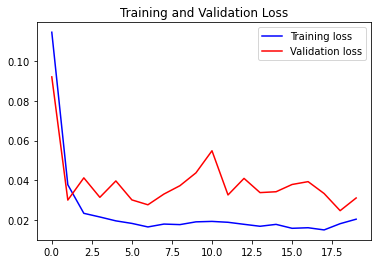

In [236]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [237]:
part_60_days = data_training.tail(60)
df = part_60_days.append(data_test, ignore_index = True)
df_backup = df.copy()
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Volume
0,46.3859,47.0216,44.2836,7.562
1,54.9425,56.4322,54.1008,10.443
2,66.9426,68.9906,62.9513,9.621
3,56.0145,57.6974,54.3144,7.362
4,57.3704,58.5065,56.8668,5.984


In [238]:
df_backup

,Date,Adj Close,Open,High,Low,Volume
0,2021-10-09,44.8428,46.3859,47.0216,44.2836,7.562
1,2021-10-10,54.6877,54.9425,56.4322,54.1008,10.443
2,2021-10-11,64.9326,66.9426,68.9906,62.9513,9.621
3,2021-10-13,57.3801,56.0145,57.6974,54.3144,7.362
4,2021-10-14,57.3458,57.3704,58.5065,56.8668,5.984
5,2021-10-15,61.6725,57.3482,62.8928,56.8748,12.148
6,2021-10-16,60.8611,61.6692,62.3292,60.1619,4.993
7,2021-10-17,61.5275,60.8655,61.6514,59.1434,5.339
8,2021-10-18,62.0563,61.5258,62.6236,60.0269,8.015
9,2021-10-19,64.2785,62.0302,64.4540,61.4510,8.016


In [239]:
df_backup.head(30)

,Date,Adj Close,Open,High,Low,Volume
0,2021-10-09,44.8428,46.3859,47.0216,44.2836,7.562
1,2021-10-10,54.6877,54.9425,56.4322,54.1008,10.443
2,2021-10-11,64.9326,66.9426,68.9906,62.9513,9.621
3,2021-10-13,57.3801,56.0145,57.6974,54.3144,7.362
4,2021-10-14,57.3458,57.3704,58.5065,56.8668,5.984
5,2021-10-15,61.6725,57.3482,62.8928,56.8748,12.148
6,2021-10-16,60.8611,61.6692,62.3292,60.1619,4.993
7,2021-10-17,61.5275,60.8655,61.6514,59.1434,5.339
8,2021-10-18,62.0563,61.5258,62.6236,60.0269,8.015
9,2021-10-19,64.2785,62.0302,64.4540,61.4510,8.016


In [240]:
inputs = scaler.transform(df)
inputs

array([[0.66286685, 0.65469112, 0.64698377, 0.00371969],
       [0.79930637, 0.80260699, 0.80414598, 0.00514172],
       [0.99065432, 1.        , 0.94583241, 0.00473599],
       ...,
       [0.46900747, 0.45941689, 0.46094798, 0.00310863],
       [0.64973411, 0.64199411, 0.63947721, 0.0039887 ],
       [0.64336068, 0.64470704, 0.65453355, 0.00218463]])

In [241]:
X_test = []
Y_test = []

In [242]:
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])

In [243]:
X_test, Y_test = np.array(X_test), np.array(Y_test) 
X_test.shape, Y_test.shape

((706, 60, 4), (706,))

In [244]:
Y_pred = model.predict(X_test)

In [245]:
scaler.scale_

array([0.01594553, 0.01571801, 0.01600886, 0.00049359])

In [246]:
scale = 1/scaler.scale_[0]

In [247]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [248]:
Y_pred

array([[45.03417  ],
       [44.709957 ],
       [44.27466  ],
       [43.704887 ],
       [42.988113 ],
       [42.126217 ],
       [41.13115  ],
       [40.016396 ],
       [38.80671  ],
       [37.530296 ],
       [36.21388  ],
       [34.88677  ],
       [33.58724  ],
       [32.326923 ],
       [31.10462  ],
       [29.914288 ],
       [28.750198 ],
       [27.608362 ],
       [26.4865   ],
       [25.38252  ],
       [24.295671 ],
       [23.219652 ],
       [22.14776  ],
       [21.076265 ],
       [19.9968   ],
       [18.907934 ],
       [17.809704 ],
       [16.712471 ],
       [15.629755 ],
       [14.572986 ],
       [13.552272 ],
       [12.5763445],
       [11.649002 ],
       [10.77366  ],
       [ 9.952473 ],
       [ 9.195425 ],
       [ 8.503308 ],
       [ 7.8790207],
       [ 7.3222504],
       [ 6.8347235],
       [ 6.400286 ],
       [ 6.0170727],
       [ 5.6808724],
       [ 5.3930616],
       [ 5.1499743],
       [ 4.9439325],
       [ 4.7703547],
       [ 4.62

In [249]:
Y_test

array([ 2.3812,  4.5341,  3.7286,  1.5972,  3.8134,  4.6393,  4.3207,
        6.518 ,  6.829 ,  5.9614,  8.9803, 14.8826,  3.3731,  3.296 ,
        4.0127,  4.0029,  3.9115,  4.0978,  4.1011,  3.8905,  3.8268,
        3.9178,  3.8633,  3.5897,  3.6247,  3.5264,  3.7929,  4.0514,
        4.5621,  4.4839,  4.6931,  2.3845,  4.5663,  3.7223,  1.8236,
        4.0064,  5.3755,  4.4147,  6.9874,  7.0992,  5.8044,  8.9445,
       13.9527,  5.5067,  5.4203,  5.5208,  5.0922,  5.1165,  4.8863,
        5.3434,  4.7967,  4.787 ,  4.8693,  4.8404,  5.128 ,  4.8474,
        4.5019,  3.9849,  4.0049,  3.8819,  2.1519,  4.5194,  4.0909,
        1.9847,  4.151 ,  4.7118,  4.2698,  6.2517,  6.598 ,  5.757 ,
        8.7453, 14.4046,  0.    ,  0.7742,  0.3677,  0.5512,  0.215 ,
        0.4455,  0.544 ,  1.3564,  1.3904,  1.3717,  1.0068,  1.6536,
        1.9296,  1.8627,  1.9103,  1.5582,  1.418 ,  1.0752,  1.5759,
        2.5299,  4.4813,  3.9461,  1.9207,  4.0703,  4.852 ,  4.2519,
        6.4086,  5.3

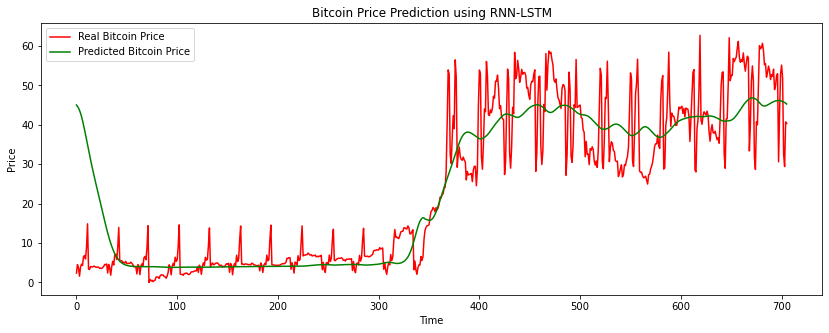

In [252]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [251]:
data

,Date,Adj Close,Open,High,Low,Volume
707,2020-01-01,7.1998,7.1964,7.2594,7.1800,42.028
676,2020-01-02,9.3816,9.3493,9.4588,9.3015,45.842
647,2020-01-03,8.5400,8.5438,8.7372,8.4372,78.405
616,2020-01-04,6.6385,6.4124,6.6613,6.1574,140.000
586,2020-01-05,8.8216,8.6286,9.0403,8.6210,111.000
555,2020-01-06,10.1893,9.4545,10.3018,9.4297,79.668
525,2020-01-07,9.2299,9.1359,9.2890,9.1011,36.678
494,2020-01-08,11.8031,11.3332,11.8477,11.2261,61.147
463,2020-01-09,11.9149,11.6442,12.0459,11.5446,58.069
433,2020-01-10,10.6205,10.7766,10.9137,10.4627,9.533


In [ ]:
plt.plot(x=data['Date'], y=data[''], color = 'red', label = 'Real Bitcoin Price')